In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets,layers,models
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
import os

data_dir = "/content/drive/MyDrive/Eye disease image dataset/Original Dataset"

for class_name in os.listdir(data_dir):
    class_path = os.path.join(data_dir, class_name)
    if os.path.isdir(class_path):
        count = len([f for f in os.listdir(class_path) if f.lower().endswith(('jpg', 'jpeg', 'png'))])
        print(f"{class_name}: {count} images")

Disc Edema: 127 images
Central Serous Chorioretinopathy [Color Fundus]: 101 images
Glaucoma: 1349 images
Diabetic Retinopathy: 1509 images
Healthy: 1024 images
Retinal Detachment: 125 images
Retinitis Pigmentosa: 139 images
Macular Scar: 444 images
Myopia: 500 images
Pterygium: 17 images


In [ ]:
dataset = tf.keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/Eye disease image dataset/Original Dataset",
    labels="inferred",
    label_mode= "categorical",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=None,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
    pad_to_aspect_ratio=False,
    data_format=None,
    verbose=True,

)

Found 5335 files belonging to 10 classes.


In [ ]:
for images, labels in dataset.take(1):
    print("Image batch shape:", images.shape)


Image batch shape: (32, 224, 224, 3)


Splitting into train dataset and validation dataset

In [ ]:
image_dir = '/content/drive/MyDrive/Eye disease image dataset/Original Dataset'

# Training dataset (80% of data)
train_ds = tf.keras.utils.image_dataset_from_directory(
    image_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical'  # for class_weight later
)

# Validation dataset (20% of data)
val_ds = tf.keras.utils.image_dataset_from_directory(
    image_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=32,
    label_mode='categorical'
)


Found 5335 files belonging to 10 classes.
Using 4268 files for training.
Found 5335 files belonging to 10 classes.
Using 1067 files for validation.


**Applying model on raw data**
1. Apply VGG16 model


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras import layers, models

# 1️⃣ Load the pretrained VGG16 base model
base_model = VGG16(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze the convolutional base
base_model.trainable = False

# 2️⃣ Add your custom classification head
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dense(10, activation='softmax')  # 10 disease classes
])

# 3️⃣ Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # because label_mode='categorical'
    metrics=['accuracy']
)

# 4️⃣ Train (fit) the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,    # start small; increase after confirming stability
    verbose=1
)

# 5️⃣ Evaluate the model
val_loss, val_acc = model.evaluate(val_ds)
print(f"✅ Validation Accuracy: {val_acc:.4f}")
print(f"📉 Validation Loss: {val_loss:.4f}")


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
Epoch 1/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 1877s 14s/step - accuracy: 0.4237 - loss: 2.5357 - val_accuracy: 0.6336 - val_loss: 1.1381
Epoch 2/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 81s 604ms/step - accuracy: 0.5702 - loss: 1.2530 - val_accuracy: 0.6167 - val_loss: 1.1160
Epoch 3/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 78s 579ms/step - accuracy: 0.6213 - loss: 1.0739 - val_accuracy: 0.6570 - val_loss: 0.9867
Epoch 4/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 74s 554ms/step - accuracy: 0.6425 - loss: 1.0145 - val_accuracy: 0.6664 - val_loss: 0.9610
Epoch 5/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 76s 568ms/step - accuracy: 0.6347 - loss: 1.0040 - val_accuracy: 0.6364 - val_loss: 1.0121
Epoch 6/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 75s 557ms/step - accuracy: 0.6503 - loss: 0.9746 - val_accuracy: 0.6701 - val_loss: 0.9578
Epoch 7/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 81s 608ms/step - accuracy: 0.6705 - loss: 0.9146 - val_accuracy: 0.6673 - val_loss: 0.9307
Epoch 8/10
134/134 ━━━━━━━━━━━━━

1.1 Evaluation

In [ ]:
# (Precision, Recall, F1
from sklearn.metrics import classification_report, confusion_matrix

# Get class names from dataset
class_names = list(train_ds.class_names)

# Collect predictions and true labels
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

# Generate detailed report
print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 235ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 313ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 226ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 259ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 231ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 239ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 223ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

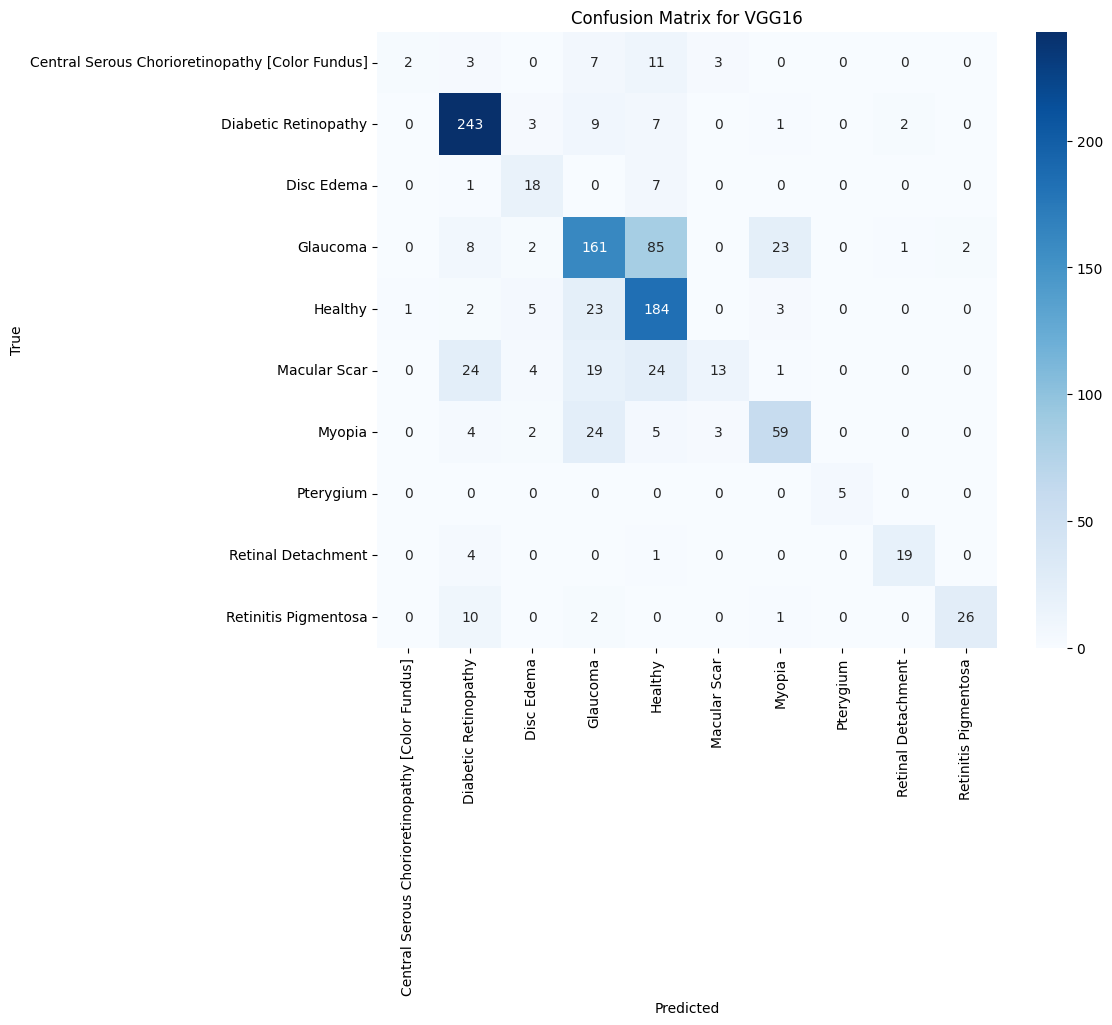

In [ ]:
#Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix for VGG16')
plt.show()


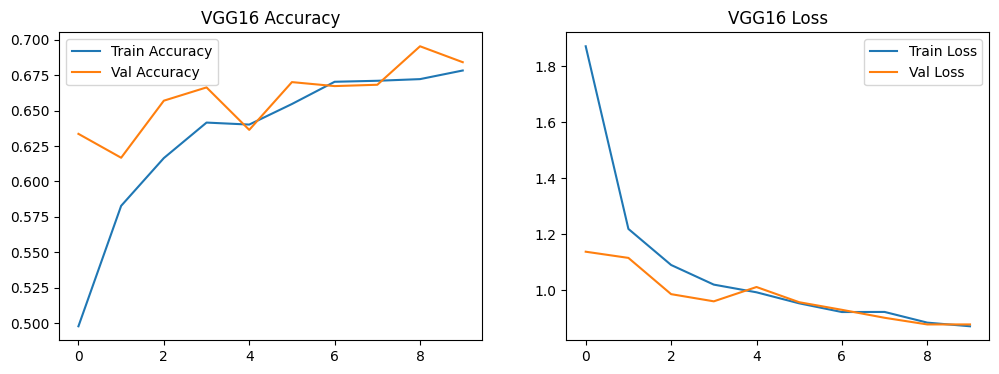

In [ ]:
# Training Performance Curves (Accuracy & Loss over Epochs)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('VGG16 Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('VGG16 Loss')
plt.show()


2. GoogleNet

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# ✅ Load pretrained InceptionV3 (modern GoogLeNet)
base_model = InceptionV3(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze base model to keep pretrained features
base_model.trainable = False

# ✅ Add custom classifier
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dense(10, activation='softmax')  # 10 classes in your dataset
])

# ✅ Compile model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',  # because label_mode='categorical'
    metrics=['accuracy']
)

# ✅ Train model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,     # increase later for fine-tuning
    verbose=1
)
val_loss, val_acc = model.evaluate(val_ds)
print(f"✅ Validation Accuracy: {val_acc:.4f}")
print(f"📉 Validation Loss: {val_loss:.4f}")


87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 126s 803ms/step - accuracy: 0.2506 - loss: 12.2472 - val_accuracy: 0.3646 - val_loss: 1.8804
Epoch 2/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 79s 591ms/step - accuracy: 0.3107 - loss: 2.0584 - val_accuracy: 0.4246 - val_loss: 1.7591
Epoch 3/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 74s 550ms/step - accuracy: 0.3671 - loss: 1.7736 - val_accuracy: 0.4114 - val_loss: 1.6900
Epoch 4/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 80s 535ms/step - accuracy: 0.4014 - loss: 1.6814 - val_accuracy: 0.4545 - val_loss: 1.6051
Epoch 5/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 73s 545ms/step - accuracy: 0.4068 - loss: 1.6260 - val_accuracy: 0.4433 - val_loss: 1.5728
Epoch 6/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 81s 606ms/step - accuracy: 0.4443 - loss: 1.5767 - val_accuracy: 0.4686 - val_loss: 1.5488
Epoch 7/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 71s 533ms/step - accuracy: 0.4506 - loss: 1.5549 - val_accuracy: 0.4564 - val_loss: 1.5751
Epoch 8/10
134/134 ━━━━━━━━━━━

2.1 Evaluation

In [ ]:
# Classification Report
class_names = list(train_ds.class_names)
y_true, y_pred = [], []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 184ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 171ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 161ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 250ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 168ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 158ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 194ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


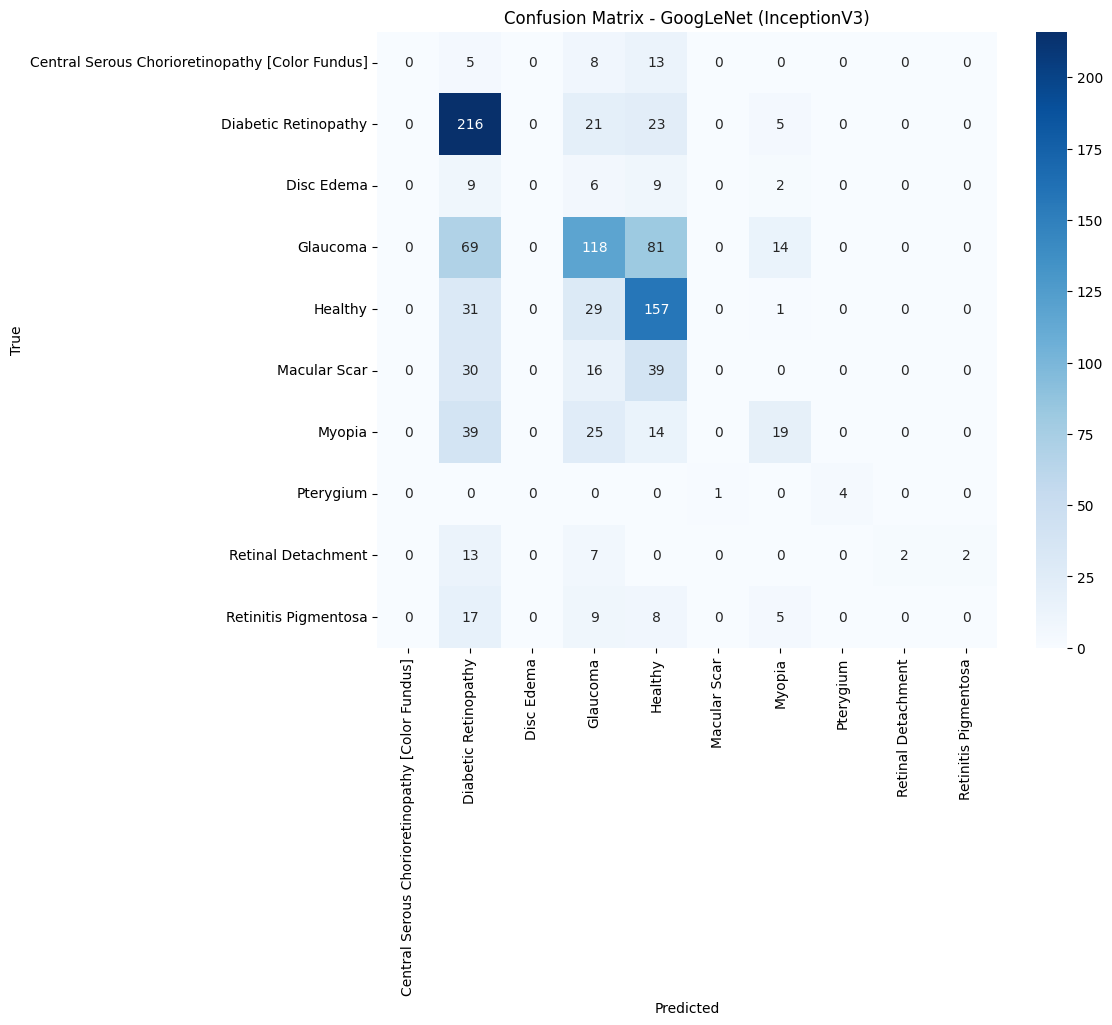

In [ ]:
# Confusino Matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - GoogLeNet (InceptionV3)')
plt.show()

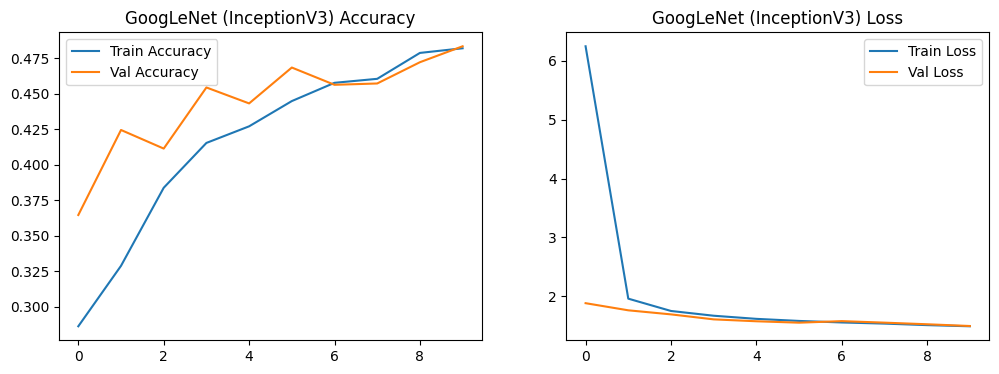

In [ ]:
# Training Curve
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('GoogLeNet (InceptionV3) Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('GoogLeNet (InceptionV3) Loss')
plt.show()


3. ResNet-50


In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# ✅ Load pretrained ResNet-50 (ImageNet weights)
base_model = ResNet50(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze convolutional base (transfer learning)
base_model.trainable = False

# ✅ Add your custom classification head
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dense(10, activation='softmax')   # 10 classes in your dataset
])

# ✅ Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',   # because label_mode='categorical'
    metrics=['accuracy']
)

# ✅ Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,      # adjust later if needed
    verbose=1
)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 98s 626ms/step - accuracy: 0.4629 - loss: 1.6632 - val_accuracy: 0.6167 - val_loss: 1.0933
Epoch 2/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 75s 558ms/step - accuracy: 0.6149 - loss: 1.0458 - val_accuracy: 0.5970 - val_loss: 1.0953
Epoch 3/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 80s 548ms/step - accuracy: 0.6566 - loss: 0.9404 - val_accuracy: 0.6729 - val_loss: 0.9044
Epoch 4/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 87s 589ms/step - accuracy: 0.6898 - loss: 0.8466 - val_accuracy: 0.6870 - val_loss: 0.8655
Epoch 5/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 72s 536ms/step - accuracy: 0.7000 - loss: 0.8135 - val_accuracy: 0.6767 - val_loss: 0.8919
Epoch 6/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 74s 550ms/step - accuracy: 0.7053 - loss: 0.8162 - val_accuracy: 0.7010 - val_loss: 0.8334
Epoch 7/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 74s 551ms/step - accuracy: 0.7088 - loss: 0.7594 - val_accuracy: 0.7067 - val_loss: 0.8328
Epoch 8/10
134/134 ━━━━━━━━━━━━━

3.1 Evaluation

In [ ]:
val_loss, val_acc = model.evaluate(val_ds)
print(f"✅ Validation Accuracy: {val_acc:.4f}")
print(f"📉 Validation Loss: {val_loss:.4f}")


34/34 ━━━━━━━━━━━━━━━━━━━━ 14s 421ms/step - accuracy: 0.6796 - loss: 0.8630
✅ Validation Accuracy: 0.6973
📉 Validation Loss: 0.8323


In [ ]:
# Recall, F1, Precision
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

class_names = list(train_ds.class_names)
y_true, y_pred = [], []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(y_true, y_pred, target_names=class_names))


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 175ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 218ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 254ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 258ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 167ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 146ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 162ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 155ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

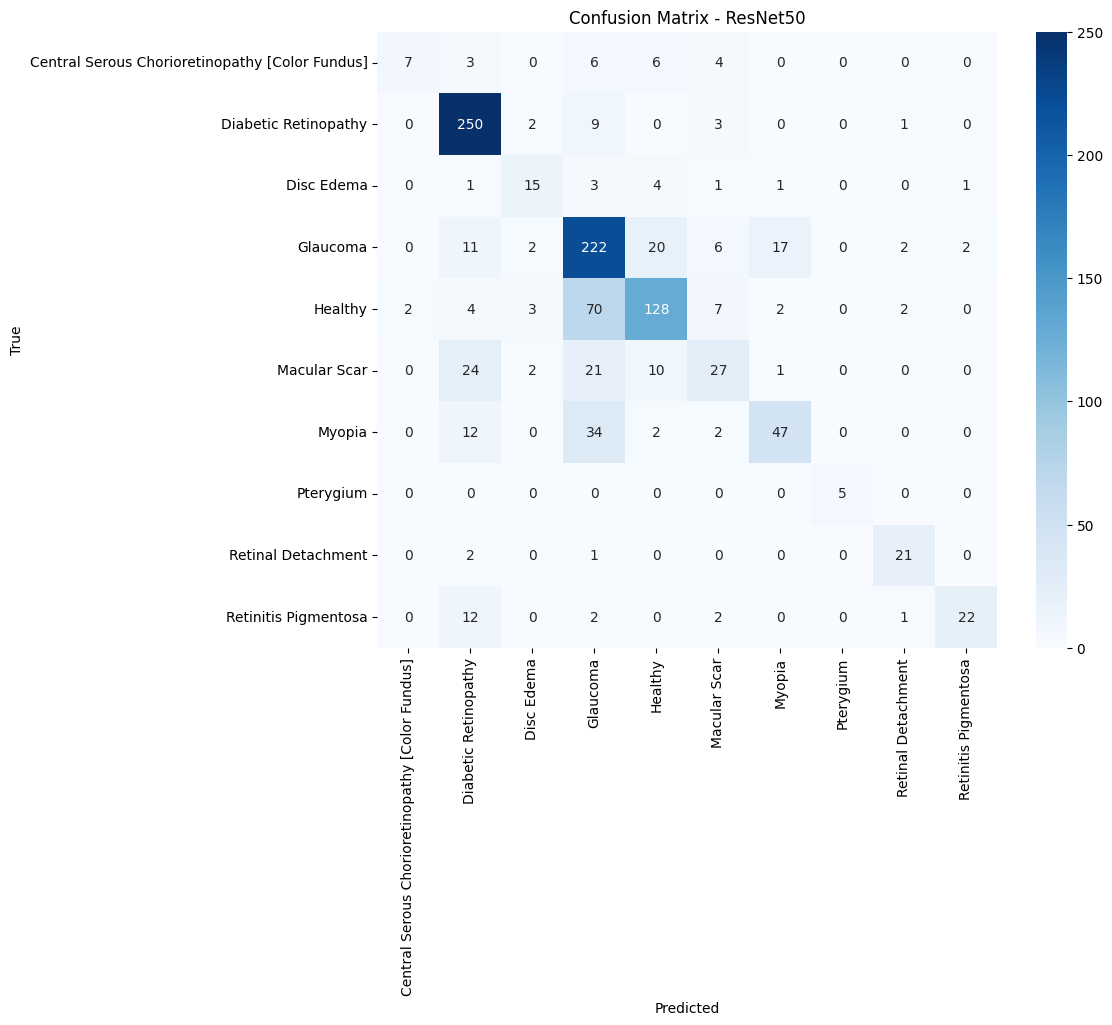

In [ ]:
# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - ResNet50')
plt.show()


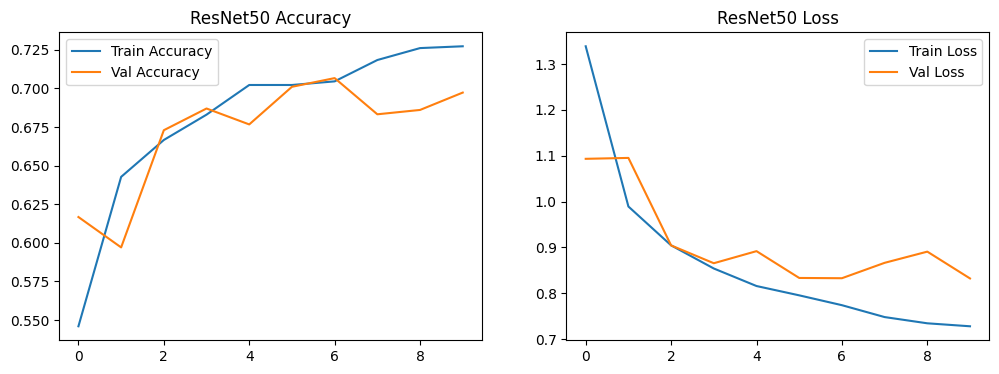

In [ ]:
# Training Curve
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('ResNet50 Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('ResNet50 Loss')
plt.show()


4. XceptionNet

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import Xception
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# ✅ Load pretrained Xception model
base_model = Xception(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze convolutional base for transfer learning
base_model.trainable = False

# ✅ Build the model
model = models.Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dropout(0.3),
    layers.Dense(256, activation='relu'),
    layers.Dense(10, activation='softmax')   # your 10 classes
])

# ✅ Compile the model
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ✅ Train the model
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,   # tune later if needed
    verbose=1
)
val_loss, val_acc = model.evaluate(val_ds)
print(f"✅ Validation Accuracy: {val_acc:.4f}")
print(f"📉 Validation Loss: {val_loss:.4f}")


83683744/83683744 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Epoch 1/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 129s 777ms/step - accuracy: 0.2656 - loss: 16.0088 - val_accuracy: 0.3871 - val_loss: 4.3719
Epoch 2/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 74s 556ms/step - accuracy: 0.3107 - loss: 4.7054 - val_accuracy: 0.3449 - val_loss: 2.2092
Epoch 3/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 73s 541ms/step - accuracy: 0.3460 - loss: 2.8915 - val_accuracy: 0.4639 - val_loss: 1.9724
Epoch 4/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 82s 544ms/step - accuracy: 0.3779 - loss: 2.3226 - val_accuracy: 0.3224 - val_loss: 1.8851
Epoch 5/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 75s 560ms/step - accuracy: 0.3622 - loss: 2.1770 - val_accuracy: 0.4424 - val_loss: 1.6477
Epoch 6/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 81s 556ms/step - accuracy: 0.3814 - loss: 1.9969 - val_accuracy: 0.4367 - val_loss: 1.6512
Epoch 7/10
134/134 ━━━━━━━━━━━━━━━━━━━━ 73s 544ms/step - accuracy: 0.4194 - loss: 1.7350 - val_accuracy: 0.4227 - val_loss: 1.6997
Epoch 8/10
134/134 ━━━━━━━━━━━

In [ ]:
#F1 Precision Call
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

class_names = list(train_ds.class_names)
y_true, y_pred = [], []

for images, labels in val_ds:
    preds = model.predict(images)
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))

print(classification_report(y_true, y_pred, target_names=class_names))


1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 178ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 170ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 181ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 193ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 185ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 188ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 195ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 211ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 183ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 174ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 197ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 217ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


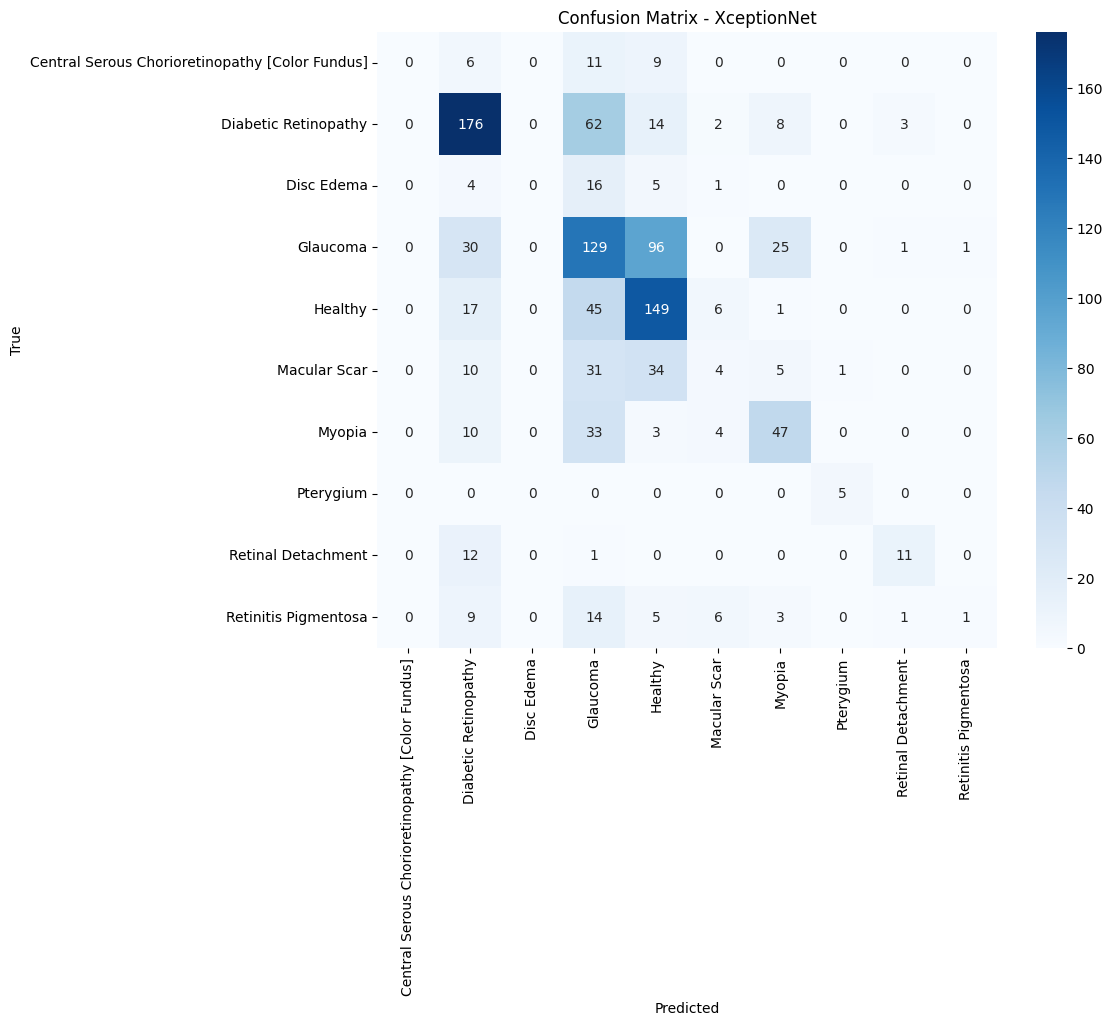

In [ ]:
# Confusion Matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names,
            yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix - XceptionNet')
plt.show()


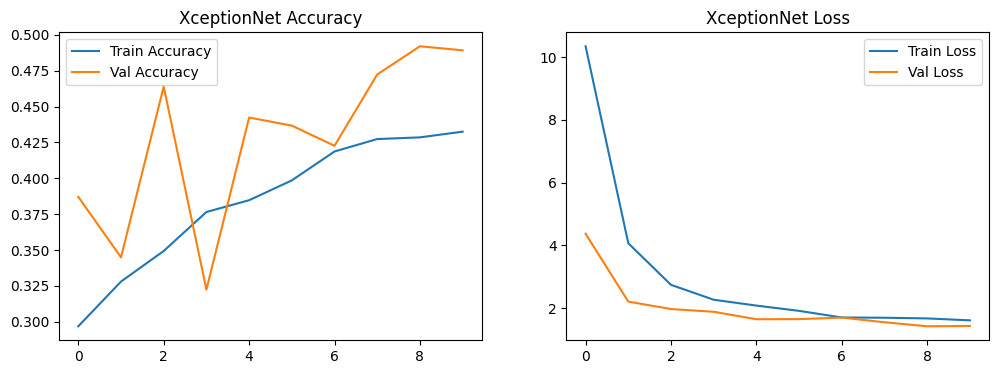

In [ ]:
# Training Curve
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.legend()
plt.title('XceptionNet Accuracy')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.title('XceptionNet Loss')
plt.show()
